## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., focal_ratio=0.3, entropy_ratio=0.7):
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon) # 避免y_pred值為0
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        focal_loss= tf.reduce_mean(reduced_fl)
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)

        return (focal_ratio*focal_loss) + (entropy_ratio*ce_loss)
    return CE_focal_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(entropy_ratio=ce_w, focal_ratio=1.-ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("ce-%s-fcl-%s" % (ce_w, 1.-ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Bat

Epoch 12/25
49/49 [==============================] - 1s 28ms/step - loss: 2.1223 - accuracy: 0.6301 - val_loss: 3.2019 - val_accuracy: 0.4851
Epoch 13/25
49/49 [==============================] - 1s 28ms/step - loss: 2.0233 - accuracy: 0.6467 - val_loss: 3.1758 - val_accuracy: 0.4868
Epoch 14/25
49/49 [==============================] - 1s 30ms/step - loss: 1.9419 - accuracy: 0.6582 - val_loss: 3.1571 - val_accuracy: 0.4979
Epoch 15/25
49/49 [==============================] - 1s 28ms/step - loss: 1.8440 - accuracy: 0.6719 - val_loss: 3.1525 - val_accuracy: 0.4970
Epoch 16/25
49/49 [==============================] - 1s 28ms/step - loss: 1.7674 - accuracy: 0.6846 - val_loss: 3.1916 - val_accuracy: 0.4970
Epoch 17/25
49/49 [==============================] - 1s 28ms/step - loss: 1.6745 - accuracy: 0.6969 - val_loss: 3.2090 - val_accuracy: 0.5015
Epoch 18/25
49/49 [==============================] - 1s 29ms/step - loss: 1.5895 - accuracy: 0.7121 - val_loss: 3.2368 - val_accuracy: 0.4976
Epoch 

Epoch 1/25
49/49 [==============================] - 3s 65ms/step - loss: 3.3950 - accuracy: 0.3039 - val_loss: 3.4480 - val_accuracy: 0.1923
Epoch 2/25
49/49 [==============================] - 1s 30ms/step - loss: 2.5672 - accuracy: 0.4168 - val_loss: 3.1256 - val_accuracy: 0.2846
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 2.3509 - accuracy: 0.4590 - val_loss: 2.7984 - val_accuracy: 0.3674
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 2.2162 - accuracy: 0.4871 - val_loss: 2.6149 - val_accuracy: 0.3977
Epoch 5/25
49/49 [==============================] - 1s 29ms/step - loss: 2.1159 - accuracy: 0.5088 - val_loss: 2.4343 - val_accuracy: 0.4315
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 2.0292 - accuracy: 0.5249 - val_loss: 2.3337 - val_accuracy: 0.4579
Epoch 7/25
49/49 [==============================] - 7s 138ms/step - loss: 1.9550 - accuracy: 0.5406 - val_loss: 2.2912 - val_accuracy: 0.4676
Epoch 8/25
4

49/49 [==============================] - 1s 29ms/step - loss: 1.0078 - accuracy: 0.6588 - val_loss: 1.4554 - val_accuracy: 0.4915
Epoch 24/25
49/49 [==============================] - 2s 31ms/step - loss: 0.9895 - accuracy: 0.6660 - val_loss: 1.4545 - val_accuracy: 0.4918
Epoch 25/25
49/49 [==============================] - 1s 28ms/step - loss: 0.9678 - accuracy: 0.6753 - val_loss: 1.4858 - val_accuracy: 0.4872


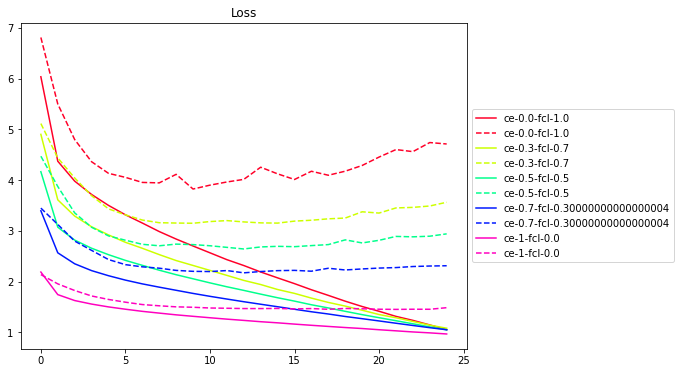

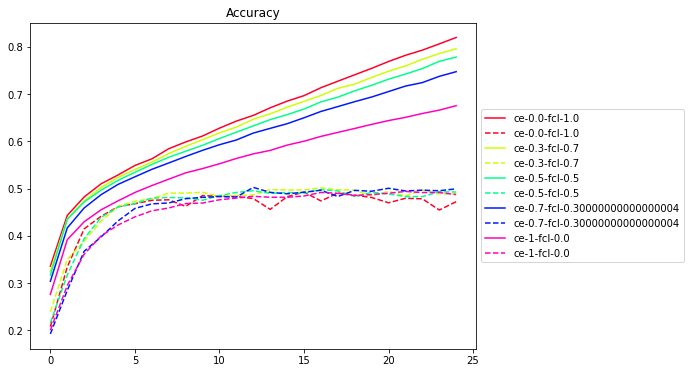

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
'''
以訓練集來看，當focal_ratio設為100%時，準確率最高為0.8197。
以驗證集來看，當focal_ratio設為70%、entropy_ratio設為30%時，準確率最高為0.4994。
'''